# Vertical

**GOAL:**  
The goal of this file is to quantitatively evaluate and visualize the Root Mean Square "Error" (RMSE), better difference, of vertical slices of temperature at the equator from multiple model configurations against the benchmark reference simulation.

---

## Imports

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Dict, Tuple, List

## Constants

In [2]:
# --- Define vertical layers of interest (depth ranges in meters) ---
DESIRED_HEIGHTS: List[Tuple[int, int]] = [
    (0, 200),      # Surface layer
    (200, 500),    # Subsurface
    (500, 2000),   # Deep ocean
    (2000, 5000),  # Abyssal
]

# --- Define longitude boundaries for ocean regions of interest ---
OCEAN_DOMAINS: Dict[str, Tuple[int, int]] = {
    "Atlantic":  (-60, 20),
    "Indian":    (30, 110),
    "Pacific W": (120, 180),
    "Pacific E": (-180, -70),
}

# --- Assign fixed colors to oceans for consistent plotting ---
ocean_names: List[str] = list(OCEAN_DOMAINS.keys())
ocean_colors: List[str] = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]
ocean_color_dict: Dict[str, str] = dict(zip(ocean_names, ocean_colors))

# --- Define the list of configurations and their descriptions ---
cfgs: List[str] = ["00", "01", "02", "04", "05", "06", "07", "08", "09", "10", "12", "14", "15", "16", "17"]
cfg_descriptions: List[str] = [
    "Benchmark",               # 00
    "Advection scheme",        # 01
    "Advection scheme",        # 02
    "Diffusion coefficient",   # 04
    "Advection scheme",        # 05
    "Diffusion coefficient",   # 06
    "Diffusion coefficient",   # 07
    "Lateral diffusion",       # 08
    "Lateral diffusion",       # 09
    "Lateral diffusion",       # 10
    "Lateral diffusion",       # 12
    "Surface current feedback",# 14
    "Lateral diffusion",       # 15
    "Physics",                 # 16
    "Physics",                 # 17
]

## Data

In [3]:
# --- Load benchmark ("reference") simulation dataset ---
DATA_DIR = os.path.expanduser("../../data/model")
ref = xr.open_dataset(
    os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc")
).sel(time_counter=slice("2011-01-01", "2022-12-31"))["to"]  # Extract temperature field


## Precompute spatial grid and boxes

In [4]:
# --- Extract coordinate arrays from the reference dataset ---
lon = ref["nav_lon_grid_T"]
depth = ref["deptht"]

# --- Construct a list of all (ocean, depth_range) analysis boxes ---
BOXES = []
for min_depth, max_depth in DESIRED_HEIGHTS:
    for ocean in ocean_names:
        lon_min, lon_max = OCEAN_DOMAINS[ocean]
        box_label = f"{ocean} {min_depth}-{max_depth}m"
        BOXES.append((box_label, ocean, min_depth, max_depth, lon_min, lon_max))

## Compute RMSE for each configuration and box

In [5]:
# --- Initialize RMSE results matrix: shape (n_cfgs, n_boxes) ---
mean_errors = np.full((len(cfgs), len(BOXES)), np.nan)

# --- Loop over configurations and compute RMSE per box ---
for i, cfg in enumerate(cfgs):
    if cfg == "00":
        continue  # Skip benchmark config (it is the reference)

    # Load model output for given configuration
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    ds = ds.sel(time_counter=slice("2011-01-01", "2022-12-31"))["to"]
    error = ref - ds

    for j, (box_label, ocean, min_depth, max_depth, lon_min, lon_max) in enumerate(BOXES):
        # Apply longitude mask
        lon_mask = (lon >= lon_min) & (lon <= lon_max)
        masked = error.where(lon_mask)

        # Apply vertical (depth) selection
        depth_mask = (depth >= min_depth) & (depth < max_depth)
        masked = masked.sel(deptht=depth[depth_mask])

        # Compute RMSE over the masked region
        rmse = np.sqrt((masked ** 2).mean(skipna=True)).item()
        mean_errors[i, j] = rmse

    ds.close()

## Plot RMSE panel by depth and basin

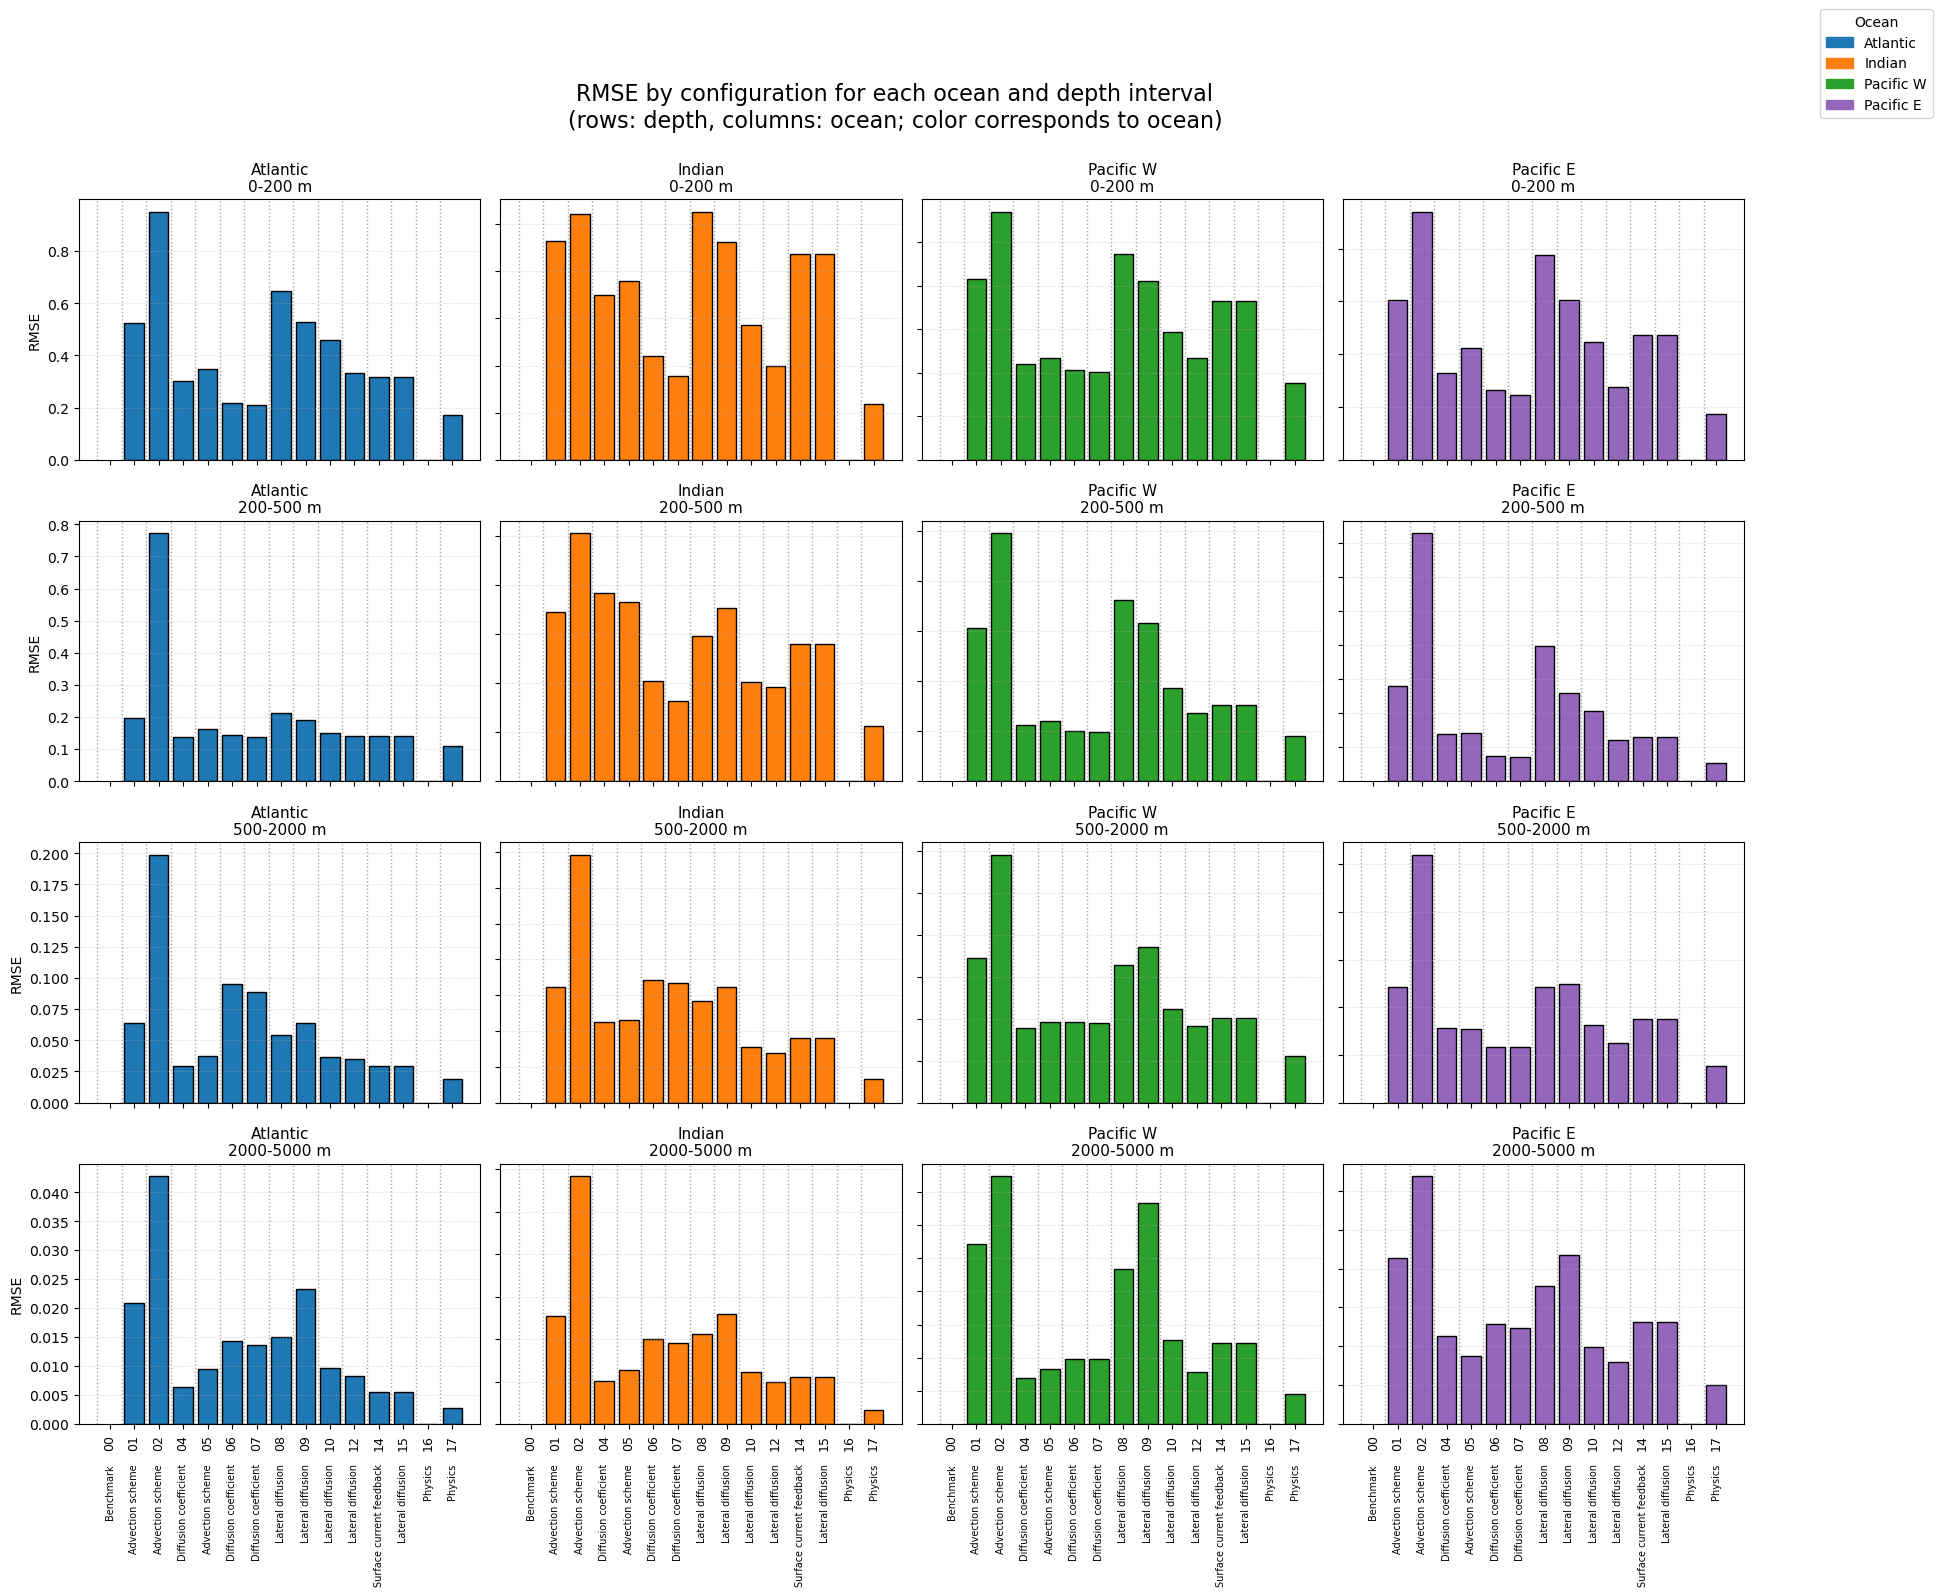

In [6]:
# --- Setup figure with subplots arranged by depth (rows) and ocean (columns) ---
n_cfg = len(cfgs)               # Number of model configurations
n_boxes = len(BOXES)            # Number of (ocean, depth) boxes
n_rows = len(DESIRED_HEIGHTS)   # Number of depth intervals (rows)
n_cols = len(ocean_names)       # Number of ocean regions (columns)

fig, axes = plt.subplots(
    nrows=n_rows, ncols=n_cols,
    figsize=(4.5 * n_cols, 4 * n_rows),
    sharex=True, sharey=False     # Share x-axis, but keep y-axis independent per depth row
)

# --- Ensure axes is always a 2D array for consistent indexing ---
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1 or n_cols == 1:
    axes = axes.reshape((n_rows, n_cols))

# --- Loop over each depth row and ocean column to plot RMSE bar charts ---
for row, (min_depth, max_depth) in enumerate(DESIRED_HEIGHTS):
    for col, ocean in enumerate(ocean_names):
        ax = axes[row, col]

        # Identify the index of the current (ocean, depth) box
        box_idx = [i for i, box in enumerate(BOXES)
                   if box[1] == ocean and box[2] == min_depth and box[3] == max_depth][0]

        heights_to_plot = mean_errors[:, box_idx]  # RMSE values for all configs in this box

        # Plot vertical bars with ocean-specific color and black edges
        ax.bar(np.arange(n_cfg), heights_to_plot, color=ocean_color_dict[ocean], edgecolor="black")

        # Set subplot title with ocean name and depth range
        ax.set_title(f"{ocean}\n{min_depth}-{max_depth} m", fontsize=11)

        # Add vertical grid lines between bars for clarity
        for xi in np.arange(n_cfg):
            ax.axvline(x=xi - 0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)

        # Add horizontal grid lines for y-axis
        ax.grid(axis='y', linestyle=':', alpha=0.5)

        # Label x-axis ticks only on the bottom row
        if row == n_rows - 1:
            ax.set_xticks(np.arange(n_cfg))
            ax.set_xticklabels(cfgs, fontsize=9, rotation=90)

            # Add vertical configuration descriptions below x-tick labels
            for j, desc in enumerate(cfg_descriptions):
                ax.text(j, ax.get_ylim()[0] - 0.15 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                        desc, rotation=90, fontsize=7, va='top', ha='center')
        else:
            ax.set_xticks([])  # Hide x-ticks for other rows

        # Set y-axis label only on the first column
        if col == 0:
            ax.set_ylabel("RMSE")
        else:
            ax.set_yticklabels([])  # Hide y-tick labels for other columns

# --- Add a common legend mapping colors to ocean names ---
handles = [Patch(color=ocean_color_dict[o], label=o) for o in ocean_names]
fig.legend(handles=handles, title="Ocean", bbox_to_anchor=(1.01, 1), loc='upper left')

# --- Add an overall figure title ---
fig.suptitle(
    "RMSE by configuration for each ocean and depth interval\n"
    "(rows: depth, columns: ocean; color corresponds to ocean)",
    y=0.95, fontsize=16
)

# --- Adjust layout to prevent overlap, save, and display figure ---
plt.tight_layout(rect=[0, 0, 0.98, 0.95])
#plt.savefig("vertical.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()